# PCA

## Import Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Read in the Data

In [34]:
# Define maturities
TENORS = ['1MO','3MO','6MO','1Y','2Y','3Y','5Y','7Y','10Y','20Y','30Y']

# Load yield changes (stationary)
df = pd.read_csv("../data/processed/cleaned_data_diffs.csv", parse_dates=['date'])
df = df.set_index('date')[TENORS].dropna()
df.head()

,1MO,3MO,6MO,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
date,,,,,,,,,,,
2001-08-01,-0.02,-0.01,0.00,0.03,0.04,0.03,0.05,0.04,0.04,0.02,0.02
2001-08-02,0.00,0.00,-0.01,0.01,0.06,0.08,0.07,0.07,0.06,0.05,0.04
2001-08-03,-0.02,-0.01,0.01,0.00,0.02,0.05,0.03,0.02,0.03,0.02,0.02
2001-08-06,-0.01,0.00,0.00,-0.01,-0.03,-0.05,-0.01,0.00,-0.01,0.00,0.00
2001-08-07,0.01,0.00,0.00,0.00,0.02,0.02,0.01,0.01,0.01,0.01,0.01


For PCA, we apply the analysis to daily changes in yields, not the raw yield levels. As shown in the EDA section, the levels of yields are non-stationary—they drift over time due to monetary policy regimes, inflation trends, and macroeconomic cycles. In contrast, yield changes are stationary, meaning they fluctuate around a stable mean with roughly constant variance.

This matters because PCA relies on the covariance matrix, and that covariance is assumed to be stable through time. When a series is non-stationary, its covariance structure drifts, and PCA ends up capturing long-term trends rather than the true co-movement of the yield curve.

By differencing the data, we remove these slow-moving trends and ensure that PCA reflects only the dynamic movements of the curve—the level, slope, and curvature changes—rather than artifacts of drift. This allows the principal components to be economically meaningful and stable across time.

## Fit PCA

In [35]:
X = df.values

pca = PCA()
X_pca = pca.fit_transform(X)

print("Explained variance ratio (first 5 PCs):")
for i, v in enumerate(pca.explained_variance_ratio_[:5]):
    print(f"PC{i+1}: {v:.3%}")

Explained variance ratio (first 5 PCs):
PC1: 68.075%
PC2: 16.462%
PC3: 7.776%
PC4: 3.895%
PC5: 1.496%


Now that the data is read in, we can apply PCA. Because our PCA is based on daily changes in yields, and those changes are all expressed in the same units (basis points), we do not standardize the data. The differences in volatility across maturities are economically meaningful—short-tenor yields naturally move more than long-tenor yields—and PCA should capture this structure rather than flatten it through scaling.

With the data prepared, we can now apply PCA using sklearn’s decomposition module. We begin by creating a PCA object and then use the fit_transform method to extract the principal components (factor time series). After fitting, we can inspect the explained_variance_ratio_ attribute to see how much of the total variance each principal component explains.

## Scree Plot

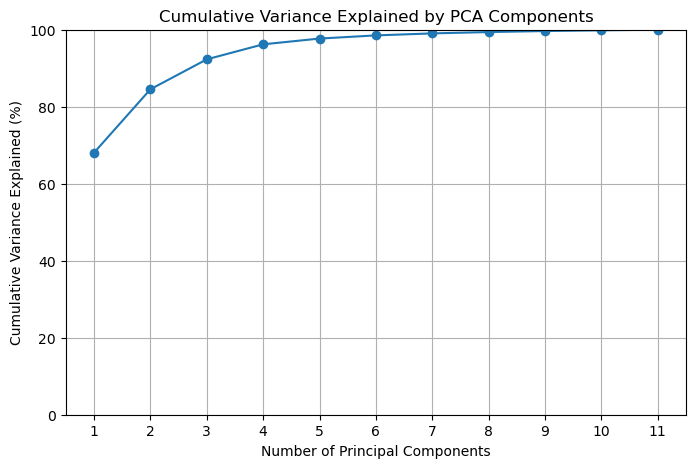

In [36]:
expl_var = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8,5))
plt.plot(range(1, len(TENORS)+1), expl_var, marker='o')
plt.title("Cumulative Variance Explained by PCA Components")
plt.xlabel("Number of Principal Components")
plt.xticks(range(1, len(TENORS)+1))
plt.ylabel("Cumulative Variance Explained (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

Now, we have created a skree plot for the PCA components. This plot shows us the amount of variance that is explained by each of the components. From this plot, we can see that over 90% of the variance is explained by the first three components.

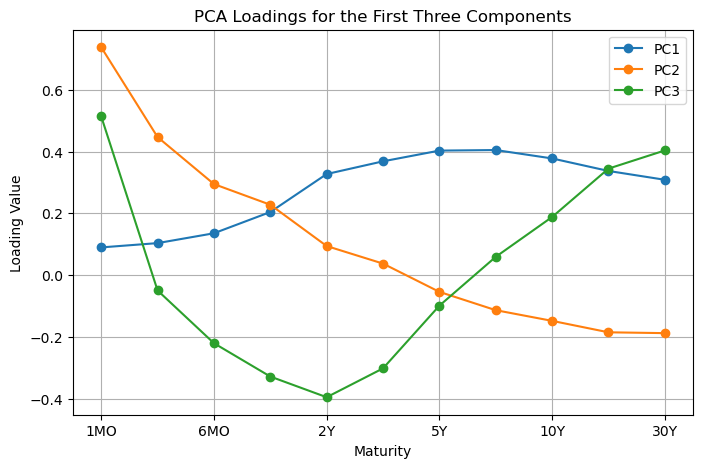

,PC1,PC2,PC3
1MO,0.089822,0.737671,0.513798
3MO,0.103743,0.446896,-0.049528
6MO,0.135604,0.294766,-0.220154
1Y,0.204333,0.227916,-0.328046
2Y,0.327250,0.094278,-0.394972
3Y,0.368434,0.037404,-0.301583
5Y,0.403117,-0.054064,-0.098717
7Y,0.404939,-0.113296,0.059328
10Y,0.377750,-0.147887,0.188317
20Y,0.337230,-0.184894,0.344814


In [37]:

loadings = pd.DataFrame(pca.components_.T, index=TENORS, 
                        columns=[f'PC{i+1}' for i in range(len(TENORS))])

for c in ['PC1','PC2','PC3']:
    if loadings[c].mean() < 0:
        loadings[c] *= -1
        X_pca[:, loadings.columns.get_loc(c)] *= -1

loadings.iloc[:, :3].plot(marker='o', figsize=(8,5))
plt.title("PCA Loadings for the First Three Components")
plt.xlabel("Maturity")
plt.ylabel("Loading Value")
plt.grid(True)
plt.show()

loadings.iloc[:, :3]

Now, let's take a look at the components themselves which are also stored as an attribute of our PCA object. For the first principal component, we see that it is positive across all tenors. This shows us that the principal components is explaining the movement of the tenors as they all move together (all move up or all move down). Therefore, we can take this to mean that the principal component is explaining the "level" of the yield curve. The second principal component is positive for the short maturities and negative for the long maturities. Therefore, this component is describing variance of the yield curve where the short maturities move up while the long maturities move down. This would be the idea of the slope of the yield curve. The final component is positive for the short maturities, negative for medium maturities, and positive for long maturities. Therefore, this component is describing how the "hump" of "U-shape" of the yield curve where short and long maturities move together and medium maturities move opposite of the other two. This would be the curvature of the yield curve.

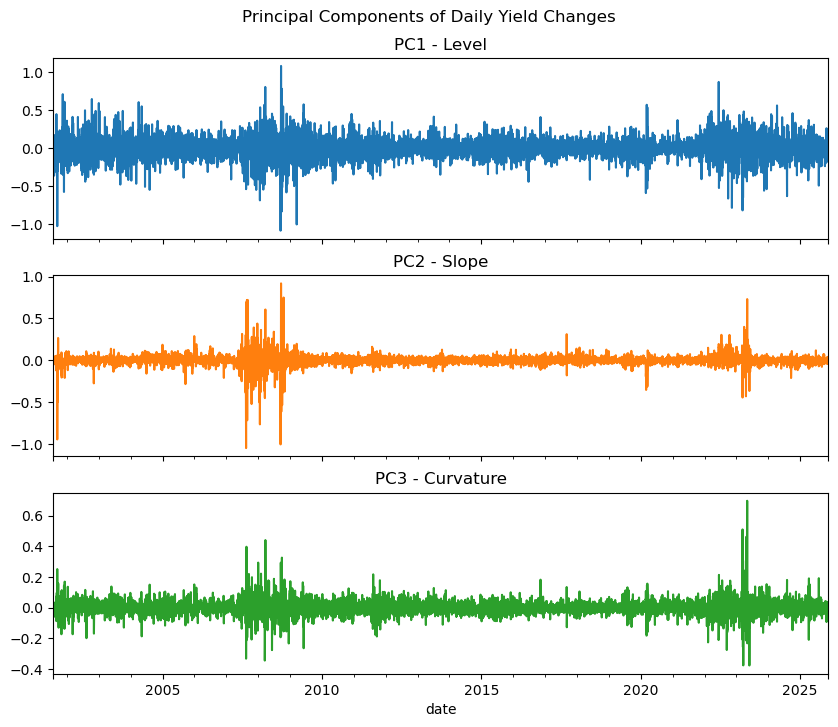

,Level,Slope,Curvature
date,,,
2001-08-01,0.092105,-0.028274,-0.024454
2001-08-02,0.158519,-0.029538,-0.006901
2001-08-03,0.068216,-0.028475,-0.016042
2001-08-06,-0.038705,-0.012517,0.024251
2001-08-07,0.033413,0.002951,0.000256


In [38]:
factors = pd.DataFrame(X_pca[:, :3], index=df.index, 
                       columns=['Level','Slope','Curvature'])

factors.plot(subplots=True, figsize=(10,8), legend=False,
             title=["PC1 - Level","PC2 - Slope","PC3 - Curvature"])
plt.suptitle("Principal Components of Daily Yield Changes", y=0.94)
plt.show()

factors.head()

Now that we have our principal components, let's work on reconstructing the yield curve from PCA loadings.